# Analisis Topik-Topik Perbincangan Berbahasa Indonesia di Twitter Seputar Koronavirus

### Pendahuluan

Pandemi koronavirus bisa dianggap sebagai peristiwa paling signifikan di tahun 2020: sampai tanggal 8 Juni, sudah ada lebih dari 6,9 juta orang yang terinfeksi dan paling tidak 400 ribu di antaranya meninggal dunia. Di Indonesia sendiri, banyaknya kasus positif telah mencapai lebih dari 31 ribu dengan jumlah kasus baru harian yang terus meningkat, menjadikan Indonesia sebagai negara dengan kasus koronavirus terbanyak ke-33 di dunia menurut New York Times (sumber: https://www.nytimes.com/interactive/2020/world/coronavirus-maps.html). Lebih buruknya, riset dari Centre for Mathematical Modelling of Infectious Diseases memperkirakan bahwa hanya sekitar 2 persen dari kasus positif koronavirus di Indonesia telah dilaporkan (sumber: https://www.bbc.com/news/world-asia-52124193).

Kita tidak bisa memungkiri bahwa pandemi koronavirus telah membawa akibat negatif bagi industri, pemerintah, dan masyarakat dalam berbagai aspek. Semenjak Indonesia mengumumkan kasus koronavirus pertamanya pada tanggal 2 Maret, berbagai usaha telah dilakukan pemerintah untuk mengurangi pesatnya penularan koronavirus. Hal ini tentunya berdampak pada pertumbuhan ekonomi dan perkembangan sosial.

Melalui studi ini, kami ingin memahami hal-hal yang umumnya dibicarakan masyarakat Indonesia semasa pandemi koronavirus ini. Kami memutuskan untuk mempelajari hal ini dengan cara menganalisis aktivitas pengguna Twitter dikarenakan kemudahan memperoleh twit-twit melalui API-nya. Selain itu, keberhasilan pelbagai studi di pelbagai disiplin (termasuk koronavirus; contoh: Ordun, Purushotham, dan Raff (2020)) dalam menggunakan data Twitter untuk mempelajari perilaku manusia menjadi faktor lain yang menjustifikasi metode riset ini.

Untuk mendapatkan twit-twit yang berkaitan dengan pandemi koronavirus, kami menggunakan kumpulan _tweet ID_ yang disaring oleh Chen, Lerman, dan Ferrara (2020). Kami mengekstraksi twit-twit yang ditulis pada minggu terakhir Januari, Februari, Maret dan April, serta pertengahan Mei dikarenakan lamanya waktu ekstraksi akibat pembatasan yang diberlakukan Twitter dalam mengambil data menggunakan API-nya. Hal ini akan dijelaskan secara lebih mendetail di bagian selanjutnya.

Pertanyaan-pertanyaan yang akan kami jawab dalam studi singkat ini adalah:

1. Apa topik-topik yang umumnya dibicarakan oleh masyarakat Indonesia semasa pandemi koronavirus ini? Adakah perbedaan dalam distribusi topik yang berarti setiap bulannya? Apakah kita bisa mengaitkan perbedaan tersebut dengan peristiwa-peristiwa seputar koronavirus yang terjadi di Indonesia?
2. Bagaimanakah pola _retweet_ dan _like_ per topik? Twit-twit dengan topik apakah yang menyebar paling cepat di kalangan masyarakat Indonesia?
3. Apa hashtag-hashtag yang umumnya digunakan dalam twit yang ditulis masyarakat Indonesia? Adakah perbedaan yang berarti setiap bulannya? Apakah kita bisa mengaitkan penggunaan hashtag dengan topik yang dibicarakan oleh masyarakat Indonesia?

Marilah kita mengimpor _package-package_ yang akan kita butuhkan.

In [4]:
import glob
import pandas as pd
import numpy as np
import json_lines
import string
import nltk
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
import pprint
from collections import Counter
import gsdmm
from gsdmm.gsdmm import MovieGroupProcess
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import stylecloud
from PIL import Image

#mengabaikan warnings
import warnings
warnings.filterwarnings('ignore')

#mengubah display sehingga bisa menampilkan paling banyak 1000 baris
pd.options.display.max_rows = 1000

### Pengambilan Data

Seperti yang dijelaskan sebelumnya, kami menggunakan _tweet ID_ dari twit-twit yang telah disaring oleh Chen et al. (2020). Setelah itu, kami menjalankan kode yang disediakan di Github mereka (https://github.com/echen102/COVID-19-TweetIDs) untuk mendapatkan atribut yang kami butuhkan untuk setiap _tweet ID_, seperti bahasa, lokasi, teks dan banyaknya _retweet_. Untuk analisis ini, kami hanya menggunakan twit orisinal (twit yang bukan merupakan hasil _retweet_). Selanjutnya, kami melakukan penyaringan bahasa dan lokasi untuk mendapatkan twit-twit yang diinginkan. Berikut adalah langkah-langkah yang kami lakukan secara lebih mendetail:

#### Langkah Pertama: Mendapatkan Twit-Twit dan Atributnya dari _Tweet ID_

Modifikasi minor dari script $\texttt{hydrate.py}$ yang mereka sediakan memungkinkan kami untuk mengambil twit-twit yang bertanggal 25-31 Januari, 23-29 Februari, 25-31 Maret, 24-30 April dan 16-22 Mei. Dengan asumsi bahwa file-file tersebut (yang berformat $\texttt{.jsonl.gz}$) telah tersedia dalam folder $\texttt{COVID-19-TweetIDs/2020-01}$, $\texttt{COVID-19-TweetIDs/2020-02}$, $\texttt{COVID-19-TweetIDs/2020-03}$, $\texttt{COVID-19-TweetIDs/2020-04}$ dan $\texttt{COVID-19-TweetIDs/2020-05}$, pengambilan twit-twit dapat dilakukan dengan cara berikut ini:

In [637]:
#mendapatkan semua file
files = glob.glob('COVID-19-TweetIDs/' + '2020-01' + '/*.gz')
files += glob.glob('COVID-19-TweetIDs/' + '2020-02' + '/*.gz')
files += glob.glob('COVID-19-TweetIDs/' + '2020-03' + '/*.gz')
files += glob.glob('COVID-19-TweetIDs/' + '2020-04' + '/*.gz')
files += glob.glob('COVID-19-TweetIDs/' + '2020-05' + '/*.gz')

#menaruh setiap tweet ID dan atributnya ke dalam dictionary
dictionary = {}
count = 0
update = 0
for file in files:
    with json_lines.open(file) as f:
        for item in f:
            id_ = item['id']
            time = item['created_at']
            lang = item['lang']
            loc = item['user']['location']
            text = item['full_text']
            ret_cnt = item['retweet_count']
            fav_cnt = item['favorite_count']
            if 'retweeted_status' in item.keys():
                temp = item['retweeted_status']
                rt_id_ = temp['id']
                rt_time = temp['created_at']
                rt_lang = temp['lang']
                rt_loc = temp['user']['location']
                rt_text = temp['full_text']
                rt_ret_cnt = temp['retweet_count']
                rt_fav_cnt = temp['favorite_count']
            else:
                rt_id_, rt_time, rt_lang, rt_loc, rt_text, rt_ret_cnt, rt_fav_cnt = [None] * 7
            if rt_id_ is None:
                rt = 0
            else:
                rt = 1
            if lang == 'in' and (rt_lang == 'in' or rt_lang == None):
                dictionary['row_' + str(count)] = [id_, time, lang, loc, text, ret_cnt,
                                              fav_cnt, rt, rt_id_, rt_time, rt_lang, rt_loc,
                                              rt_text, rt_ret_cnt, rt_fav_cnt]
            count += 1
    update += 1
    print(str(update) + ' out of ' + str(len(files)), end='\r')

#mentransformasi dictionary ke dalam bentuk dataframe
df = pd.DataFrame.from_dict(dictionary, orient='index',
                       columns=['id', 'time', 'lang', 'loc', 'text', 'ret_cnt', 'fav_cnt',
                               'rt', 'rt_id', 'rt_time', 'rt_lang', 'rt_loc',
                               'rt_text', 'rt_ret_cnt', 'rt_fav_cnt'])

In [638]:
df.head()

,id,time,lang,loc,text,ret_cnt,fav_cnt,rt,rt_id,rt_time,rt_lang,rt_loc,rt_text,rt_ret_cnt,rt_fav_cnt
0,1222490921272365056,Wed Jan 29 12:05:23 +0000 2020,in,Dompu NTB,RT @Ab1id__Dz039: #BongkarSkandalPDIP_KPU\n\nK...,28.0,0.0,1.0,1.222425e+18,Wed Jan 29 07:44:29 +0000 2020,in,"California, USA",#BongkarSkandalPDIP_KPU\n\nKapan Nih FERGUSO I...,28.0,43.0
1,1222490921964462080,Wed Jan 29 12:05:23 +0000 2020,in,"Kuala Lumpur, Wilayah Persekutuan Kuala Lumpur",RT @edjunaidi: Buat apa halang pelancong China...,1782.0,0.0,1.0,1.222158e+18,Tue Jan 28 14:02:09 +0000 2020,in,"Kuala Lumpur, MY",Buat apa halang pelancong China dari masuk Mal...,1782.0,1610.0
2,1222490923352748032,Wed Jan 29 12:05:23 +0000 2020,in,di depan mu,@YongL4dy @kopassos @idtodayco Rkyt udh paham ...,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1222490925491871745,Wed Jan 29 12:05:24 +0000 2020,in,Kuala Lumpur ☁,RT @ketengahketepi: I masih tak boleh terima l...,67.0,0.0,1.0,1.222466e+18,Wed Jan 29 10:27:57 +0000 2020,in,NaN,I masih tak boleh terima la dia makan anak tik...,67.0,93.0
4,1222490926339149824,Wed Jan 29 12:05:24 +0000 2020,in,NaN,"Disaat lagi heboh dengan virus corona, dan say...",0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [639]:
df.shape

(984324, 15)

_Dataframe_ ini mengandung hampir satu juta baris dan 15 kolom. Untuk setiap _tweet ID_ , kami mengambil atribut-atribut ini:

1. _Tweet ID_
2. Waktu penulisan
3. Bahasa
4. Lokasi pengguna
5. Teks twit
6. Banyaknya _retweet_
7. Banyaknya _like_
8. _Tweet ID_ dari twit orisinal (jika ada)
9. Waktu penulisan dari twit orisinal (jika ada)
10. Bahasa dari twit orisinal (jika ada)
11. Lokasi pengguna dari twit orisinal (jika ada)
12. Teks dari twit orisinal (jika ada)
13. Banyaknya _retweet_ dari twit orisinal (jika ada)
14. Banyaknya _like_ dari twit orisinal (jika ada)

Untuk setiap _tweet ID_ , atribut nomor 8-14 ada jika dan hanya jika twit dengan _tweet ID_ tersebut adalah sebuah _retweet_. Dari kode di atas, bisa dilihat bahwa kami hanya mengambil twit berbahasa Indonesia yang mana bahasa dari twit orisinalnya adalah bahasa Indonesia (jika ada). Walaupun pastinya terdapat twit-twit berbahasa Inggris yang ditulis oleh masyarakat Indonesia, kami memutuskan untuk menaruh fokus pada twit-twit berbahasa Indonesia demi memudahkan pemrosesan data.

Satu hal minor yang perlu disampaikan adalah kolom $\texttt{rt}$ pada _dataframe_ di atas bernilai 1 jika sebuah tweet adalah _retweet_, dan bernilai 0 jika tidak.

#### Langkah Kedua: Membuang _Retweet_

Karena analisis ini berfokus pada twit orisinal, kami membuang twit-twit yang merupakan hasil _retweet_ dari twit lain. Secara konkret, untuk _tweet ID_ tanpa atribut 8-14, kami mengambil atribut 1-7 karena _tweet ID_ tersebut merujuk pada twit orisinal. Selain itu, kami mengambil atribut 8-14. Pada langkah ini, kami juga membuang banyak twit duplikat yang dihasilkan.

In [641]:
#membuang retweet
df_left = df[df.rt == 0][['id', 'time', 'lang', 'loc', 'text', 'ret_cnt', 'fav_cnt']]
df_right = df[df.rt == 1][['rt_id', 'rt_time', 'rt_lang', 'rt_loc', 'rt_text', 'rt_ret_cnt', 'rt_fav_cnt']]
df_right.columns = ['id', 'time', 'lang', 'loc', 'text', 'ret_cnt', 'fav_cnt']
df_combined = pd.concat([df_left, df_right])

#membuang duplikat berdasarkan tweet ID
df_combined = df_combined.sort_values('ret_cnt', ascending=False).drop_duplicates('id').sort_index()
df_combined = df_combined.reset_index(drop=True)

#mengubah semua teks menjadi huruf kecil
df_combined = df_combined.applymap(lambda s: s.lower() if type(s) == str else s)

In [645]:
#membuang duplikat berdasarkan tweet ID
df_combined = df_combined.sort_values('ret_cnt', ascending=False).drop_duplicates('id').sort_index()
df_combined = df_combined.reset_index(drop=True)

#mengubah semua teks menjadi huruf kecil
df_combined = df_combined.applymap(lambda s: s.lower() if type(s) == str else s)

In [646]:
df_combined.head()

,id,time,lang,loc,text,ret_cnt,fav_cnt
0,1254455244995457024,sun apr 26 17:00:11 +0000 2020,in,NaN,kangen jalan² ke pantai. corona cepat pergi si...,1.0,8.0
1,1254455249198354434,sun apr 26 17:00:12 +0000 2020,in,NaN,@wabbasi007 @muhktiyra_ lock down sirf masajid...,0.0,0.0
2,1231987159793623040,mon feb 24 17:00:02 +0000 2020,in,"kota batam, kepulauan riau","mereka bertaruh nyawa, ini kompensasi bagi pet...",0.0,0.0
3,1.243e+18,thu mar 26 02:04:54 +0000 2020,in,"jakarta, indonesia",pangeran charles dinyatakan positif virus coro...,52.0,138.0
4,1222490923352748032,wed jan 29 12:05:23 +0000 2020,in,di depan mu,@yongl4dy @kopassos @idtodayco rkyt udh paham ...,0.0,1.0


In [647]:
df_combined.shape

(399415, 7)

Setelah membuang duplikat, sekarang _dataframe_ kami mengandung kurang lebih 400 ribu baris.

#### Langkah Ketiga: Menyaring Lokasi

Kami memutuskan untuk melakukan langkah ini dikarenakan banyaknya twit berbahasa non-Indonesia yang dikategorikan sebagai twit berbahasa Indonesia (dari kolom $\texttt{lang}$). Dengan menyaring twit-twit yang berlokasi di Indonesia (contoh: Jakarta, Madiun, East Java), twit-twit yang tersisa berpeluang besar untuk benar-benar ditulis menggunakan berbahasa Indonesia. Perlu dicatat bahwa proses ini tidaklah sempurna: terdapat banyak pengguna yang tidak menuliskan lokasi mereka atau dengan sengaja mengubah lokasi mereka. Kendati demikian, teknik penyaringan yang mudah dilakukan ini menghasilkan relatif banyak twit berbahasa Indonesia.

Analisis kami menghasilkan keyword-keyword berikut, yang kami anggap sebagai lokasi-lokasi di Indonesia:

In [648]:
keywords = ['indonesia', 'jakarta', 'java', 'jawa', 'sumatera', 'sumatra', 
            'sulawesi', 'kalimantan', 'borneo', 'papua', 'bali', 'bandung', 
            'yogyakarta', 'surabaya', '+62', 'nkri', 'malang',
            'bekasi', 'bogor', 'aceh', 'makassar', 'semarang', 'batam',
            'riau', 'tangerang', 'banten', 'medan', 'pekanbaru', 'lampung',
            'depok', '🇮🇩', 'samarinda', 'surakarta', 'palembang', 'graha bnpb',
            'polsek', 'pontianak', 'nusantara', 'pedesaan',
            'magelang', 'jkt', 'solo', 'jogja', 'banjarmasin',
            'kebayoran', 'purwokerto', 'jember', 'denpasar', 'jambi', 'sidoarjo',
            'kritik kebijakan', 'bengkulu', 'cirebon', 'jabodetabek', 'bdg',
            'sukabumi', 'cilangkap', 'inews tower', 'sleman', 'netizenpronkri',
            'serpong', 'kertosono', 'banyuwangi', 'purworejo', 'tanjung pinang',
            'tasikmalaya', 'menteri supeno', 'klaten', 'tunggal ika', 'mataram',
            'batavia', 'bangka', 'palangka raya', 'gorontalo', 'bintaro', 'bantul',
            'jateng', 'mojokerto', 'lombok', 'bukittinggi', 'padang', 'kediri',
            'cengkareng', 'tuban', 'purwakarta', 'manado', 'salatiga', 'tegal', 
             'madiun', 'cimahi', 'pattimura', 'bojonegoro', 'milono', 'mojok', 
             'lamongan', 'probolinggo', 'pamekasan', 'pancasila', 'magetan',
             'palangkaraya', 'cilacap', 'indramayu', 'ponorogo', 'sunda', 'bangkinang',
             'pekalongan', 'medan merdeka', 'kebumen', 'jepara', 'jekardah', 'gresik',
             'jayapura', 'karawang', 'banjarmasin', 'pati', 'sutami', 'parasamya',
             'tulungagung', 'lumajang', 'pakubuwono', 'betawi', 'bantul', 'jambi',
             'bangka', 'yogja', 'wkwkland', 'kudus', 'kominfo', 'bengkulu', 'banjarbaru',
             'tangsel', 'jatinangor', 'wonosobo', 'jaksel', 'pematangsiantar', 'madura',
             'sragen', 'kaltim', 'gunungkidul', 'gorontalo', 'cibubur', 'kendari',
             'magetan', 'dpr ri', 'kulon progo', 'suroboyo', 'boyolali', 'ambon']

In [650]:
#dataframe setelah mengaplikasikan filter lokasi
df_filtered = df_combined[pd.notnull(df_combined['loc'])]
df_filtered = df_filtered[df_filtered.apply(lambda r: any([kw in r['loc'] for kw in keywords]), axis=1)]

In [651]:
df_filtered.head()

,id,time,lang,loc,text,ret_cnt,fav_cnt
2,1231987159793623040,mon feb 24 17:00:02 +0000 2020,in,"kota batam, kepulauan riau","mereka bertaruh nyawa, ini kompensasi bagi pet...",0.0,0.0
3,1.243e+18,thu mar 26 02:04:54 +0000 2020,in,"jakarta, indonesia",pangeran charles dinyatakan positif virus coro...,52.0,138.0
7,1242997564183465984,thu mar 26 02:11:27 +0000 2020,in,"jawa timur, indonesia","@dewirahmat_ ketika corona sudah reda, dan kit...",0.0,1.0
9,1231987167523557381,mon feb 24 17:00:04 +0000 2020,in,"jatiuwung, tangerang",@hestiaaapri iya ni ada kandungan virus corona:(,0.0,0.0
13,1254455270316494848,sun apr 26 17:00:17 +0000 2020,in,indonesia,@imeldaveroo @imeldaveroo lagi rapuh karna ken...,0.0,0.0


In [652]:
df_filtered.shape

(149677, 7)

_Dataframe_ kami sekarang mengandung kurang lebih 150 ribu baris. Pemrosesan data siap untuk dilakukan!

### Pemrosesan Data

Kami melakukan teknik pemrosesan data standar yang meliputi:

1. Pembuangan tautan pada teks
2. Lematisasi teks menggunakan $\textit{package}$ $\texttt{Sastrawi}$ yang didesain khusus untuk teks berbahasa Indonesia (https://pypi.org/project/Sastrawi/)
3. Tokenisasi teks menggunakan $\texttt{TweetTokenizer}$ dari $\textit{package}$ $\texttt{NLTK}$
4. Pembuangan _stopword_

Kami juga mengumpulkan _hashtag-hashtag_ yang disebut dalam teks, yang nantinya akan dianalisis kemudian.

In [653]:
#mendapatkan hashtag
def get_hashtags(text):
    list_of_hashtags = []
    temp = text.split()
    for word in temp:
        if word[0] == '#':
            list_of_hashtags.append(word)
    return list_of_hashtags

#stopwords
stop = open("stop.txt", "r")
stopwords = stop.read().splitlines()
stopwords += StopWordRemoverFactory().get_stop_words()

#stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

#tokenizer
tknzr = nltk.tokenize.TweetTokenizer()

def stemmed(text):
    #pembuangan tautan
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', "", text)
    #lematisasi
    text = stemmer.stem(text)
    #tokenisasi
    text = tknzr.tokenize(text)
    #pembuangan stopword
    text = [x for x in text if x not in stopwords]
    return text    

In [654]:
texts = list(df_filtered['text'])
df_filtered['hashtags'] = [get_hashtags(text) for text in texts]
df_filtered['stemmed'] = [stemmed(text) for text in texts]

#pembuangan duplikat
df_filtered = df_filtered.drop_duplicates(['time', 'text']).shape

In [738]:
df_filtered.head()

,id,time,text,ret_cnt,fav_cnt,hashtags,stemmed
0,1.233770e+18,sat feb 29 15:05:13 +0000 2020,"3 pemain tertular virus corona, klub liga ital...",6.0,7.0,[],"[3, main, tular, virus, corona, klub, liga, it..."
1,1.254743e+18,mon apr 27 12:04:03 +0000 2020,angka virus corona covid-19 diprediksi terus t...,7.0,22.0,[],"[angka, virus, corona, covid, -, 19, prediksi,..."
2,1.231166e+18,sat feb 22 10:38:22 +0000 2020,"tunda pernikahan demi rawat pasien, dokter mud...",4.0,28.0,[],"[tunda, nikah, rawat, pasien, dokter, muda, te..."
3,1.231168e+18,sat feb 22 10:45:03 +0000 2020,"tunda pernikahan demi rawat pasien, dokter mud...",1.0,7.0,[],"[tunda, nikah, rawat, pasien, dokter, muda, te..."
4,1.254368e+18,sun apr 26 11:14:02 +0000 2020,pakar hukum: omnibus law ciptaker bisa jadi so...,1.0,3.0,[],"[pakar, hukum, omnibus, law, ciptaker, solusi,..."


In [692]:
df_filtered.shape

(146642, 7)

Setelah proses ini, kami menyadari bahwa banyak stopword yang tidak terbuang karena ditulis dalam bentuk singkat (contoh: yg, dgn, kpn). Selain itu, terdapat beberapa stopword berbahasa Inggris yang sering digunakan orang Indonesia (contoh: what, lol), serta kata-kata tidak baku yang sering digunakan (contoh: himbau, nafas). Untuk mengatasi hal ini, kami mengambil kata-kata yang dengan frekuensi kemunculan terbanyak (paling sedikit 100 kali), dan melakukan pemetaan secara manual untuk membersihkan korpus kami. Kami juga membuang angka, kata-kata dengan kurang dari dua karakter, serta kata-kata yang muncul lebih dari 20000 kali. Dalam melakukan pemodelan topik nantinya, kami hanya menggunakan kata-kata yang telah melalui proses pemetaan.

In [49]:
all_words = [word for item in list(df_filtered['stemmed']) for word in item]

#distribusi frekuensi dari kata-kata
fdist = nltk.FreqDist(all_words)

#banyaknya kata unik
len(fdist)

100344

In [50]:
#mengubah distribusi frekuensi ke dalam dataframe
fdist = pd.DataFrame.from_dict(fdist, orient='index').reset_index()
fdist.columns = ['word', 'freq']
fdist = fdist.sort_values('freq', ascending=False)

In [51]:
#membuang kata dengan <= 1 karakter
fdist = fdist[fdist.apply(lambda r: len(r['word']) > 1, axis=1)]

#membuang angka
fdist = fdist[fdist.apply(lambda r: r['word'].isdigit() == False, axis=1)]

#memilih kata yang muncul >= 100 kali dan <= 20000 kali
fdist = fdist[(fdist.freq >= 100) & (fdist.freq <= 20000)]

In [724]:
fdist.head()

,word,freq
179,orang,12949
17,indonesia,12571
103,perintah,9558
186,sebar,9121
119,pandemi,8920


Menggunakan kata-kata di atas, kami melakukan pemetaan secara manual dan hasilnya kami simpan dalam $\texttt{fdist.csv}$.

In [2]:
fdist = pd.read_csv('fdist.csv').iloc[:,1:]
fdist.head(10)

,word,freq,map
0,orang,12949,NaN
1,indonesia,12571,NaN
2,perintah,9558,NaN
3,sebar,9121,NaN
4,pandemi,8920,NaN
5,lockdown,8807,NaN
6,positif,8542,NaN
7,rumah,8359,NaN
8,china,7517,cina
9,aja,7506,no


Pemetaan dilakukan dengan mengikuti aturan sederhana sebagai berikut:

1. Kata tidak baku -> kata baku
2. Stopword dan kata tanpa arti -> no

Selanjutnya, sebuah kolom baru bernama $\texttt{cleaned}$ dibuat untuk merefleksikan pemetaan tersebut.

In [740]:
#dictionary untuk mengumpulkan aturan pemetaan
dict_word = {}
for i in range(len(fdist)):
    temp = fdist.iloc[i]
    word = temp['word']
    map_ = temp['map']
    if type(map_) != str:
        dict_word[word] = word
    elif map_ != 'no':
        dict_word[word] = map_

#pemetaan
df_filtered['cleaned'] = df_filtered.apply(lambda row: [dict_word[x] for x in 
                                                        row.stemmed if x in dict_word.keys() ], axis=1)
#penghapusan stopword (untuk memastikan tidak ada stopword yang tersisa)
df_filtered['cleaned'] = df_filtered.apply(lambda row: [x for x in row.cleaned if x not in stopwords], axis=1)

_Word cloud_ di bawah ini menunjukkan kata-kata yang paling sering muncul dari twit-twit yang sudah dibersihkan.

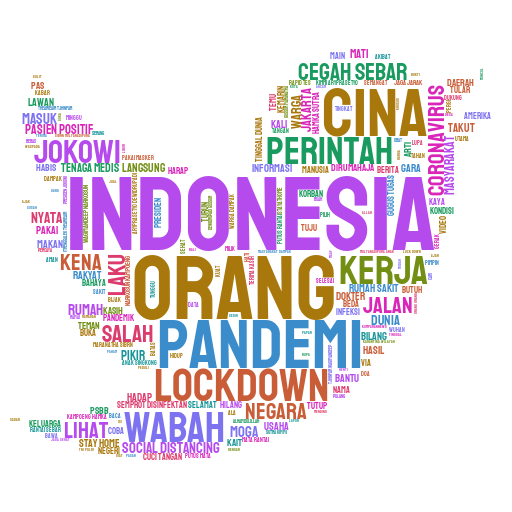

In [76]:
df_filtered['cleaned_text'] = df_filtered['cleaned'].apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_filtered['cleaned_text'].values))
stylecloud.gen_stylecloud(text=long_string, icon_name='fab fa-twitter', max_words=200, palette='cmocean.sequential.Phase_11', output_name='twitter-all-words.png')
Image.open('twitter-all-words.png')

Untuk memudahkan analisis, kami juga menambahkan kolom $\texttt{month}$ yang merujuk kepada bulan ditulisnya sebuah twit.

In [742]:
def month(time):
    return time.split(' ')[1]
    
df_filtered['month'] = df_filtered.apply(lambda r: month(r['time']), axis=1)

In [743]:
df_filtered.head()

,id,time,text,ret_cnt,fav_cnt,hashtags,stemmed,cleaned,month
0,1.233770e+18,sat feb 29 15:05:13 +0000 2020,"3 pemain tertular virus corona, klub liga ital...",6.0,7.0,[],"[3, main, tular, virus, corona, klub, liga, it...","[main, tular, liga, italia, masuk, karantina]",feb
1,1.254743e+18,mon apr 27 12:04:03 +0000 2020,angka virus corona covid-19 diprediksi terus t...,7.0,22.0,[],"[angka, virus, corona, covid, -, 19, prediksi,...","[angka, prediksi, turun, rakyat, indonesia, ha...",apr
2,1.231166e+18,sat feb 22 10:38:22 +0000 2020,"tunda pernikahan demi rawat pasien, dokter mud...",4.0,28.0,[],"[tunda, nikah, rawat, pasien, dokter, muda, te...","[tunda, nikah, rawat, pasien, dokter, muda, te...",feb
3,1.231168e+18,sat feb 22 10:45:03 +0000 2020,"tunda pernikahan demi rawat pasien, dokter mud...",1.0,7.0,[],"[tunda, nikah, rawat, pasien, dokter, muda, te...","[tunda, nikah, rawat, pasien, dokter, muda, te...",feb
4,1.254368e+18,sun apr 26 11:14:02 +0000 2020,pakar hukum: omnibus law ciptaker bisa jadi so...,1.0,3.0,[],"[pakar, hukum, omnibus, law, ciptaker, solusi,...","[pakar, hukum, omnibus, law, solusi]",apr


Sekarang, kita siap untuk melakukan pemodelan topik!

### Pemodelan Topik

Mari kita menganalisis beberapa hal dasar terkait teks-teks yang akan dianalisis.

In [4]:
all_words = [word for item in list(df_filtered['cleaned']) for word in item]

#distribusi frekuensi kata-kata
fdist = nltk.FreqDist(all_words)
print('Banyaknya kata unik: ',len(fdist))

Banyaknya kata unik:  1873


Kode di atas menunjukkan bahwa sekarang terdapat 1.873 kata unik. Sekarang, kita akan menghitung distribusi banyaknya kata per teks.

Rata-rata panjang teks:  7.153550824456841
Modus panjang teks:  4
Banyaknya teks dengan panjang 0:  5963
Banyaknya teks dengan panjang 1:  10301


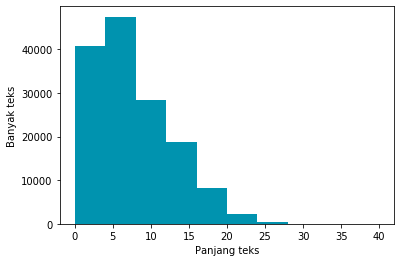

In [11]:
length = [len(x) for x in df_filtered['cleaned']]
plt.hist(length, color='#0093AF');
plt.xlabel('Panjang teks')
plt.ylabel('Banyak teks')
print('Rata-rata panjang teks: ', np.mean(length))
print('Modus panjang teks: ', np.argmax(np.bincount(length)))
print('Banyaknya teks dengan panjang 0: ', length.count(0))
print('Banyaknya teks dengan panjang 1: ', length.count(1))

Dari sini bisa dilihat bahwa teks-teks yang akan kita analisis sangat pendek. Terdapat banyak pula twit di mana semua kata-kata penyusunnya (atau semua kecuali satu) tidak ada dalam kelompok kata-kata yang sudah kami petakan. Contoh twit yang demikian adalah "kita memang siap": ketiga kata penyusun twit ini masuk dalam _list_ _stopword_ (kata-kata yang tidak memiliki nilai semantik dalam penyusunan topik), sehingga setelah dibersihkan twit ini mengandung 0 kata. Untuk analisis selanjutnya, kami memutuskan untuk membuang teks-teks demikian.

In [6]:
df_filtered = df_filtered[df_filtered.apply(lambda r: len(r['cleaned']) >= 2, axis=1)]
df_filtered.shape

(130378, 9)

Mari kita menggambar histogram baru setelah penyaringan di atas.

Rata-rata panjang teks:  7.96691159551458


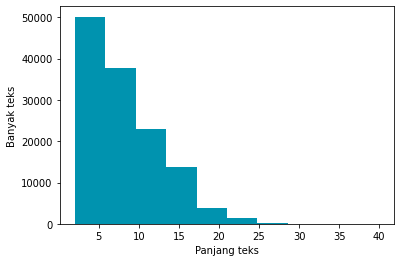

In [7]:
length = [len(x) for x in df_filtered['cleaned']]
plt.hist(length, color='#0093AF');
plt.xlabel('Panjang teks')
plt.ylabel('Banyak teks')
print('Rata-rata panjang teks: ', np.mean(length))

Sekarang, kita akan menganalisis banyaknya twit per bulan.

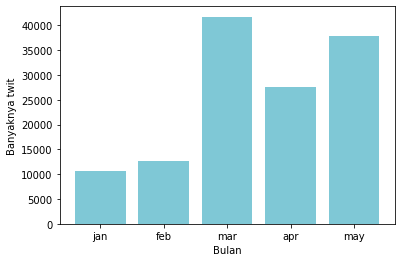

In [9]:
tweets_per_month = df_filtered.groupby('month')[['id']].agg('count')
tweets_per_month = tweets_per_month.reindex(['jan', 'feb', 'mar', 'apr', 'may'])
plt.bar(tweets_per_month.index, tweets_per_month.id, align='center', alpha=0.5, color='#0093AF');
plt.xlabel('Bulan');
plt.ylabel('Banyaknya twit');

Dari _bar chart_ di atas, bisa dilihat bahwa twit-twit yang kami analisis kebanyakan ditulis pada bulan Maret dan Mei. Pesatnya peningkatan jumlah twit dari awal Februari ke awal Maret kemungkinan disebabkan karena koronavirus pertama kali terdeteksi di Indonesia pada bulan Maret (sumber: https://nasional.kompas.com/read/2020/03/03/06314981/fakta-lengkap-kasus-pertama-virus-corona-di-indonesia).

Pemodelan topik akan dilakukan dengan dua metode, yakni Latent Dirichlet Allocation (LDA), yang bisa dilihat di http://ethen8181.github.io/machine-learning/clustering/topic_model/LDA.html dan https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html, serta Short Text Topic Modeling (STTM), yang bisa dilihat di https://towardsdatascience.com/short-text-topic-modeling-70e50a57c883. Terdapat banyak penelitian yang menyimpulkan bahwa performa LDA buruk pada teks-teks singkat (silakan membaca https://stackoverflow.com/questions/29786985/whats-the-disadvantage-of-lda-for-short-texts untuk memahami hal ini lebih lanjut). Kita telah melihat betapa singkatnya teks-teks yang akan dianalisis, sehingga LDA mungkin bukan merupakan pilihan yang tepat. Mari kita lihat apakah kita bisa memverifikasi hal tersebut! 

### Analisis dengan LDA

Untuk analisis ini, kami membiarkan parameter $\texttt{alpha}$ dan $\texttt{eta}$ dipelajari dari data dengan menambahkan argumen $\texttt{alpha = 'auto'}$ dan $\texttt{eta = 'auto'}$. Kami tidak melakukan _hyperparameter tuning_ karena menjalankan LDA untuk dokumen sebesar ini memerlukan waktu yang sangat lama.

Kami melakukan 40 $\textit{passes}$ melalui keseluruhan korpus. Untuk menentukan banyaknya topik, metrik yang kami gunakan adalah $\textit{coherence score}$ (silakan membaca https://stats.stackexchange.com/questions/375062/how-does-topic-coherence-score-in-lda-intuitively-makes-sense untuk memahami hal ini lebih lanjut). Secara konkret, kami mencoba 6, 10, 15 dan 20 topik dan memilih banyaknya topik yang menghasilkan $\textit{coherence score}$ terbesar.

In [803]:
#persiapan
texts = list(df_filtered['cleaned'])
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

#memilih banyaknya topik berdasarkan coherence score
num_topics = [6, 10, 15, 20]
coherences = []
models = []

for num_topic in num_topics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topic, 
                                           random_state=100,
                                           update_every=3,
                                           chunksize=5000,
                                           passes=40,
                                           alpha='auto',
                                           eta='auto',
                                           eval_every=None)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherences.append(coherence_score)
    models.append(lda_model)

In [804]:
coherences

[0.4045968868045105,
 0.4968927857306943,
 0.5030554447274794,
 0.49566287586354607]

Dari hasil di atas, banyaknya topik yang menghasilkan _coherence score_ terbesar adalah 15. Namun, karena 10 topik menghasilkan _coherence score_ yang mirip, kami memutuskan untuk memilih 10 topik.

Mari kita analisis topik-topik yang dihasilkan lebih lanjut.

In [805]:
lda_model = models[1]
pp = pprint.PrettyPrinter()
pp.pprint(lda_model.print_topics())

[(0,
  '0.049*"moga" + 0.045*"pandemi" + 0.044*"sehat" + 0.030*"cepat" + '
  '0.028*"lawan" + 0.024*"hidup" + 0.024*"selamat" + 0.023*"allah" + '
  '0.018*"ramadan" + 0.014*"wabah"'),
 (1,
  '0.036*"orang" + 0.031*"rumah" + 0.017*"kena" + 0.015*"lockdown" + '
  '0.013*"pakai" + 0.013*"lihat" + 0.013*"kerja" + 0.012*"salah" + '
  '0.011*"sakit" + 0.010*"jaga"'),
 (2,
  '0.093*"indonesia" + 0.061*"cina" + 0.039*"negara" + 0.030*"wabah" + '
  '0.029*"jokowi" + 0.026*"perintah" + 0.021*"rakyat" + 0.017*"dunia" + '
  '0.016*"presiden" + 0.015*"amerika"'),
 (3,
  '0.073*"sebar" + 0.065*"cegah" + 0.038*"laku" + 0.023*"polri" + '
  '0.018*"tugas" + 0.017*"masyarakat" + 0.016*"kabupaten" + '
  '0.015*"disinfektan" + 0.014*"tangan" + 0.014*"upaya"'),
 (4,
  '0.057*"mudik" + 0.047*"tes" + 0.039*"putus" + 0.027*"sebar" + '
  '0.026*"rantai" + 0.024*"obat" + 0.023*"mata" + 0.022*"kampung" + '
  '0.021*"hasil" + 0.021*"vaksin"'),
 (5,
  '0.096*"positif" + 0.078*"pasien" + 0.065*"orang" + 0.059*"ting

Untuk setiap topik, kita bisa melihat 10 kata yang dominan. Dari kata-kata tersebut, kita bisa menginterpretasi topik-topik di atas sebagai berikut:

- Topik 0: twit mengenai **harapan agar pandemi koronavirus segera berakhir**
- Topik 1: twit mengenai **_stay-at-home order_ dan _lockdown_**
- Topik 2: twit mengenai **datangnya koronavirus dari Cina dan upaya negara untuk mendapatkan bantuan (alat medis) dari AS dan Cina dalam menangani koronavirus**
- Topik 3: twit mengenai **upaya pemerintah dan POLRI dalam pencegahan penyebaran koronavirus melalui penyemprotan disinfektan**
- Topik 4: twit mengenai **mudik lebaran dan efeknya terhadap penyebaran koronavirus**
- Topik 5: twit mengenai **kasus positif koronavirus dan pentingnya _social distancing_**
- Topik 6: tidak jelas; sepertinya datang dari _spam_
- Topik 7: twit mengenai **_lockdown_ di berbagai daerah di Indonesia dan dunia, juga rencana PSBB di Indonesia**
- Topik 8: twit mengenai **bantuan medis dan sosial untuk masyarakat di masa pandemi koronavirus**
- Topik 9: twit mengenai **aspek medis koronavirus, termasuk berbagai informasi dan saran medis terkait koronavirus**

Sekarang, mari melihat distribusi twit per topik.

In [812]:
topics = []
dist = lda_model.get_document_topics(corpus)
for i in range(0, len(dist)):
    topics.append(sorted(dist[i], key=lambda x: x[1], reverse=True)[0][0])

df_filtered['lda_topic'] = topics

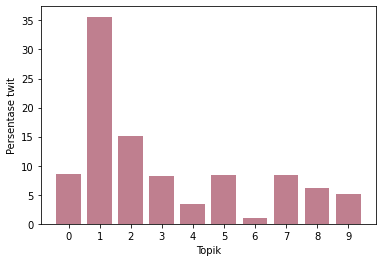

In [14]:
lda_dist = df_filtered.groupby('lda_topic')[['id']].count().reset_index()
lda_dist['sum'] = np.sum(lda_dist['id'])
lda_dist['pct'] = 100 * lda_dist['id'] / lda_dist['sum']

plt.bar(lda_dist.lda_topic, lda_dist.pct, align='center', alpha=0.5, color='#800020');
plt.xlabel('Topik');
plt.xticks(np.arange(np.min(lda_dist.lda_topic), np.max(lda_dist.lda_topic)+1, 1));
plt.ylabel('Persentase twit');

Dari sini, bisa dilihat bahwa mayoritas twit tergolong dalam topik 1, dan sangat sedikit twit tergolong dalam topik 6. Hal ini masuk akal karena topik 6 adalah _spam_ yang kita deteksi dan topik 1 adalah tentang pentingnya _lockdown_ dan _stay-at-home_ order untuk memberantas koronavirus. Mari kita lihat apakah kita mendapatkan _bar chart_ yang serupa untuk setiap bulannya.

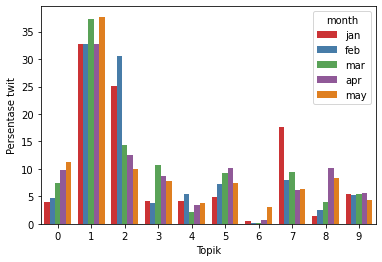

In [15]:
lda_dist = df_filtered.groupby(['month', 'lda_topic'])[['id']].count().reset_index()
lda_dist_sum = lda_dist.groupby('month').agg({'id': 'sum'}).reset_index()
lda_dist = lda_dist.merge(lda_dist_sum, on = 'month', how = 'left')
lda_dist['pct'] = 100 * lda_dist['id_x']/lda_dist['id_y']
ax = sns.barplot(x='lda_topic', hue='month', hue_order = ['jan', 'feb', 'mar', 'apr', 'may'], y='pct', data=lda_dist, palette='Set1')
ax.set(xlabel = 'Topik', ylabel = 'Persentase twit')
plt.show()

Dari sini, kita bisa melihat bahwa topik 1 dan 2 adalah topik yang dominan setiap bulannya; popularitas topik 1 cukup stabil, sedangkan popularitas topik 2 cenderung menurun. Hipotesis kami ini dikarenakan topik 2 adalah tentang asal mula koronavirus dari Cina, yang ramai dibicarakan di bulan Januari dan Februari; sedangkan sisanya adalah tentang bantuan alat medis dari Cina dan Amerika, yang sangat dibutuhkan pada bulan Maret dan April.

Kita juga bisa melihat peningkatan pada popularitas topik 0, 5, dan 8, yang masuk akal mengingat jumlah kasus koronavirus di Indonesia yang terus meningkat. Hal ini mendorong orang-orang untuk menulis twit mengenai 1) harapan mereka agar pandemi cepat berakhir dan kegiatan kembali seperti semula, 2) pentingnya _social distancing_ dan banyaknya kasus positif koronavirus, dan 3) bantuan medis dan sosial di masa koronavirus.

Terdapat pula peningkatan pesat pada popularitas topik 3 di bulan Maret, yang mungkin adalah imbas dari meningkatnya kasus korona di Indonesia, di mana polisi mulai menyemprotkan disinfektan di rumah warga yang menjadi _suspect_ atau pasien koronavirus. Aksi-aksi ini banyaknya dilakukan dan diperintahkan di bulan Maret (sumber: https://news.detik.com/berita/d-4957124/kapolri-perintahkan-jajaran-semprot-disinfektan-massal-cegah-corona).

Penurunan pada popularitas topik 7 adalah sesuatu yang tidak terduga mengingat betapa efektifnya _lockdown_ dalam mencegah penyebaran koronavirus. Hipotesis kami mengatakan bahwa ini adalah karena twit-twit mengenai perintah _stay-at-home_ dan _lockdown_ terbagi dua dalam topik 1 dan 7.

Sebagai pelengkap, kami tampilkan _bar chart_ yang menunjukkan jumlah twit untuk masing-masing topik di bawah ini.

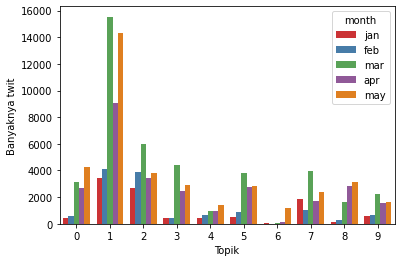

In [19]:
lda_dist = df_filtered.groupby(['month', 'lda_topic'])[['id']].count().reset_index()
ax = sns.barplot(x='lda_topic', hue='month', hue_order = ['jan', 'feb', 'mar', 'apr', 'may'], y='id', data=lda_dist , palette='Set1')
ax.set(xlabel = 'Topik', ylabel = 'Banyaknya twit')
plt.show()

Sekarang, mari kita menganalisis banyaknya _retweet_ dan _like_ per topik.

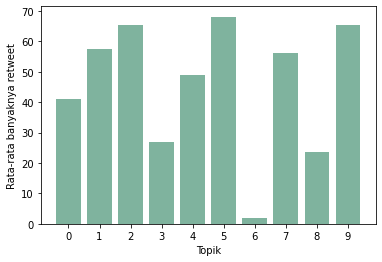

In [25]:
ret_cnt_dist = df_filtered.groupby('lda_topic').agg({'ret_cnt': 'mean'}).reset_index()
plt.bar(ret_cnt_dist.lda_topic, ret_cnt_dist.ret_cnt, align='center', alpha=0.5, color='#00693E');
plt.xlabel('Topik');
plt.xticks(np.arange(np.min(lda_dist.lda_topic), np.max(lda_dist.lda_topic)+1, 1));
plt.ylabel('Rata-rata banyaknya retweet');

Dari sini, bisa kita lihat bahwa topik-topik yang paling sering di-$\textit{retweet}$ adalah topik 2, 5, dan 9. Mari kita menganalisis apakah pola yang sama dapat diobservasi setiap bulannya.

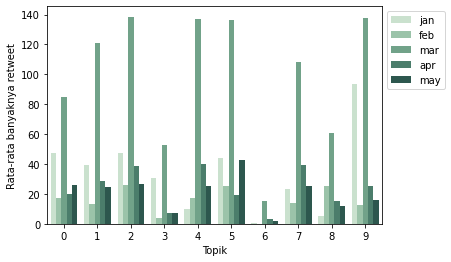

In [23]:
ret_cnt_dist = df_filtered.groupby(['month','lda_topic']).agg({'ret_cnt': 'mean'}).reset_index()
ax = sns.barplot(x='lda_topic', hue='month', hue_order = ['jan', 'feb', 'mar', 'apr', 'may'], y='ret_cnt', data=ret_cnt_dist, palette='ch:2.5,-.2,dark=.3');
ax.set(xlabel = 'Topik', ylabel = 'Rata-rata banyaknya retweet');
plt.legend(bbox_to_anchor=(1, 1));
plt.show();

Hal paling signifikan yang bisa dilihat pada _bar chart_ berikut ini adalah betapa banyaknya _retweet_ untuk setiap topik pada bulan Maret. Kita juga dapat melihat bahwa topik-topik yang cenderung jarang di-_retweet_ setiap bulannya adalah topik 3, 6, dan 8. Terdapat banyak sekali _retweet_ mengenai topik 9 pada bulan Januari, yang mungkin disebabkan oleh banyaknya masyarakat yang belum familiar dengan koronavirus. Selain itu, tidak ada hal berarti lain yang bisa disimpulkan dari _bar chart_ di atas.

Sekarang, kita akan melakukan hal yang sama untuk menganalisis banyaknya _like_.

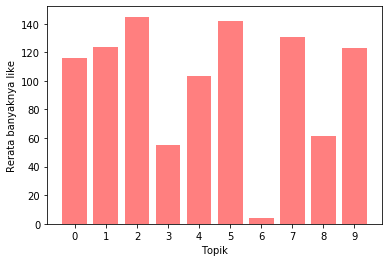

In [21]:
fav_cnt_dist = df_filtered.groupby('lda_topic').agg({'fav_cnt': 'mean'}).reset_index()
plt.bar(fav_cnt_dist.lda_topic, fav_cnt_dist.fav_cnt, align='center', alpha=0.5, color='red');
plt.xlabel('Topik');
plt.xticks(np.arange(np.min(lda_dist.lda_topic), np.max(lda_dist.lda_topic)+1, 1));
plt.ylabel('Rerata banyaknya like');

Dari sini, bisa didapatkan bahwa topik-topik yang paling sering di-_like_ adalah topik 2, 5, dan 9, sama dengan hasil di atas. Mari kita menganalisis apakah pola yang sama dapat diobservasi setiap bulannya.

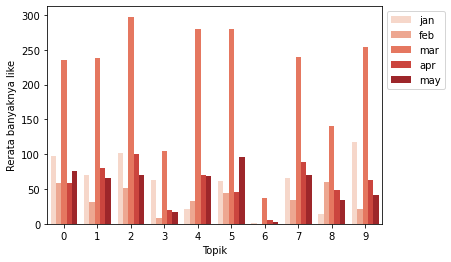

In [28]:
fav_cnt_dist = df_filtered.groupby(['month','lda_topic']).agg({'fav_cnt': 'mean'}).reset_index()
ax = sns.barplot(x='lda_topic', hue='month', hue_order = ['jan', 'feb', 'mar', 'apr', 'may'], y='fav_cnt', data=fav_cnt_dist, palette='Reds');
ax.set(xlabel = 'Topik', ylabel = 'Rerata banyaknya like');
plt.legend(bbox_to_anchor=(1, 1));
plt.show();

Kita mendapatkan _bar chart_ yang cukup mirip dengan _bar chart_ di atas! Hal ini menunjukkan korelasi yang cukup kuat antara banyaknya _like_ dan _retweet_.

### Analisis dengan STTM

Sekarang, kita akan mengulangi analisis yang sama dengan metode STTM. Kami memutuskan untuk menggunakan 10 topik. Kami juga tidak melakukan _hyperparameter tuning_, dan memilih untuk menggunakan nilai parameter _default_ untuk _alpha_ dan _beta_.

Untuk melakukan STTM, kami menggunakan implementasi GSDMM yang bisa diunduh dari https://github.com/rwalk/gsdmm.

In [887]:
docs = df_filtered['cleaned'].tolist()
vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)

mgp = gsdmm.gsdmm.MovieGroupProcess(K=10, alpha=0.1, beta=0.1, n_iters=30)
y = mgp.fit(docs, n_terms)

In stage 0: transferred 115957 clusters with 10 clusters populated
In stage 1: transferred 91540 clusters with 10 clusters populated
In stage 2: transferred 53003 clusters with 10 clusters populated
In stage 3: transferred 39521 clusters with 10 clusters populated
In stage 4: transferred 34223 clusters with 10 clusters populated
In stage 5: transferred 31995 clusters with 10 clusters populated
In stage 6: transferred 31133 clusters with 10 clusters populated
In stage 7: transferred 30520 clusters with 10 clusters populated
In stage 8: transferred 29795 clusters with 10 clusters populated
In stage 9: transferred 29656 clusters with 10 clusters populated
In stage 10: transferred 29409 clusters with 10 clusters populated
In stage 11: transferred 29184 clusters with 10 clusters populated
In stage 12: transferred 28790 clusters with 10 clusters populated
In stage 13: transferred 28860 clusters with 10 clusters populated
In stage 14: transferred 28636 clusters with 10 clusters populated
In s

Mari kita menganalisis 10 kata yang paling sering muncul dari setiap topik yang dihasilkan.

In [889]:
for i in range(10):
    print('Cluster ' + str(i))
    print(sorted(mgp.cluster_word_distribution[i].items(),key = operator.itemgetter(1),reverse = True)[:10])
    print('*' * 20)

Cluster 0
[('cina', 2317), ('wuhan', 1960), ('indonesia', 1593), ('wni', 1490), ('evakuasi', 1105), ('warga', 1023), ('negara', 915), ('perintah', 888), ('coronavirus', 631), ('masuk', 546)]
********************
Cluster 1
[('anak', 1025), ('thearieair', 923), ('tjhinfar', 920), ('hamka', 916), ('sutra', 915), ('narkosun', 910), ('wagimandeep', 909), ('kimmi', 900), ('aryprasetyo', 898), ('kampoeng', 894)]
********************
Cluster 2
[('lockdown', 4587), ('perintah', 3069), ('indonesia', 1590), ('laku', 1507), ('sebar', 1471), ('psbb', 1464), ('jokowi', 1393), ('warga', 1356), ('mudik', 1178), ('masyarakat', 1174)]
********************
Cluster 3
[('cina', 4727), ('indonesia', 4466), ('orang', 3623), ('negara', 2872), ('mati', 1674), ('perintah', 1649), ('wabah', 1478), ('jokowi', 1477), ('rakyat', 1404), ('dunia', 1332)]
********************
Cluster 4
[('cegah', 2432), ('sebar', 1908), ('polri', 1755), ('laku', 1320), ('semprot', 1267), ('disinfektan', 1228), ('laksana', 971), ('masy

Untuk setiap topik, kita bisa melihat 10 kata yang dominan. Dari kata-kata tersebut, kita bisa menginterpretasi topik-topik di atas sebagai berikut:

- Topik 0: twit mengenai **koronavirus di Cina, khususnya Wuhan, dan evakuasi warga negara Indonesia**
- Topik 1: tidak jelas; lagi-lagi ini sepertinya datang dari _spam_, dan ini konsisten dengan topik 6 dari LDA.
- Topik 2: twit mengenai **perintah _lockdown_, PSBB, dan larangan mudik di Indonesia**
- Topik 3: twit mengenai **penyebaran di berbagai negara dan hubungan dengan luar negeri**
- Topik 4: twit mengenai **upaya pencegahan penyebaran koronavirus yang dilakukan pemerintah, seperti penyemprotan disinfektan oleh polisi**
- Topik 5: twit mengenai **_stay-at-home_ order dan _lockdown_, serta kegiatan-kegiatan dan keluhan selama _stay-at-home_**
- Topik 6: twit mengenai **bantuan untuk tenaga medis, dan bantuan sosial dan medis untuk masyarakat di masa pandemi koronavirus**
- Topik 7: twit mengenai **kasus positif koronavirus, termasuk pasien yang sembuh, dan dilakukannya tes koronavirus**
- Topik 8: twit mengenai **dampak pandemi koronavirus terhadap perekonomian Indonesia**
- Topik 9: twit mengenai **upaya pencegahan penyebaran koronavirus yang bisa dilakukan masyarakat, seperti _social distancing_, menggunakan masker, dan tetap di rumah** (mirip dengan topik 5)

Bisa dilihat bahwa topik-topik yang dihasilkan oleh STTM lumayan mirip dengan topik-topik yang dihasilkan oleh LDA. Sekarang, mari melihat distribusi twit per topik.

In [900]:
topics = []
for i in range(len(docs)):
    topics.append(mgp.choose_best_label(docs[i])[0])
    
df_filtered['sttm_topic'] = topics

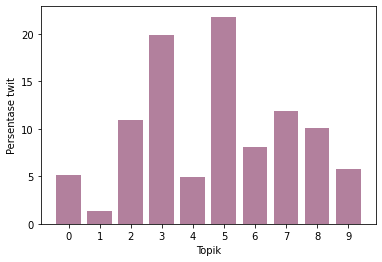

In [31]:
sttm_dist = df_filtered.groupby('sttm_topic')[['id']].count().reset_index()
sttm_dist['sum'] = np.sum(sttm_dist['id'])
sttm_dist['pct'] = 100 * sttm_dist['id'] / sttm_dist['sum']

plt.bar(sttm_dist.sttm_topic, sttm_dist.pct, align='center', alpha=0.5, color='#66023C');
plt.xlabel('Topik');
plt.xticks(np.arange(np.min(sttm_dist.sttm_topic), np.max(sttm_dist.sttm_topic)+1, 1));
plt.ylabel('Persentase twit');

Dari sini, bisa dilihat bahwa mayoritas twit tergolong dalam topik 3 dan 5, dan sangat sedikit twit tergolong dalam topik 1. Hal ini wajar karena topik 1 di sini adalah _spam_ dan topik 3 dan 5 berbicara mengenai penyebaran koronavirus dan perintah _stay-at-home_. Mari kita lihat apakah kita mendapatkan _bar chart_ yang serupa untuk setiap bulannya.

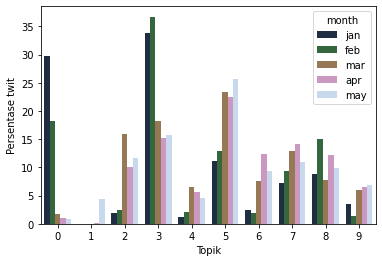

In [38]:
sttm_dist = df_filtered.groupby(['month', 'sttm_topic'])[['id']].count().reset_index()
sttm_dist_sum = sttm_dist.groupby('month').agg({'id': 'sum'}).reset_index()
sttm_dist = sttm_dist.merge(sttm_dist_sum, on = 'month', how = 'left')
sttm_dist['pct'] = 100 * sttm_dist['id_x']/sttm_dist['id_y']
ax = sns.barplot(x='sttm_topic', hue='month', hue_order = ['jan', 'feb', 'mar', 'apr', 'may'], y='pct', data=sttm_dist, palette='cubehelix');
ax.set(xlabel = 'Topik', ylabel = 'Persentase twit');
plt.show();

Dari _bar chart_ di atas, diperoleh bahwa topik 3 dan 5 cenderung populer setiap bulannya. Namun, popularitas topik 3 cenderung berkurang dan popularitas topik 5 cenderung meningkat. Hipotesis kami adalah penerapan PSBB dan _stay-at-home_ di Indonesia pada bulan April-Mei meningkatkan popularitas topik 5, sementara bertambahnya penyebaran virus dalam negeri (dibandingkan penyebaran virus luar negeri) menyebabkan popularitas topik 3 menurun.

Popularitas topik 0 menunjukkan penurunan drastis; hal ini masuk akal karena evakuasi warga negara Indonesia di Wuhan umumnya terjadi pada bulan Januari dan Februari. Seperti diperkirakan, kita melihat kenaikan pada popularitas topik 2 dan 5 yang berkaitan dengan _lockdown_.

Sekarang, mari kita menganalisis banyaknya _retweet_ dan _like_ per topik.

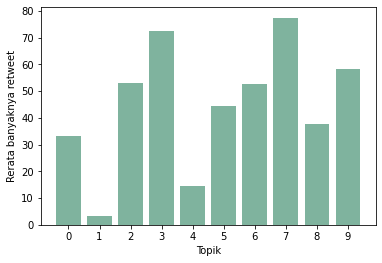

In [39]:
ret_cnt_dist = df_filtered.groupby('sttm_topic').agg({'ret_cnt': 'mean'}).reset_index()
plt.bar(ret_cnt_dist.sttm_topic, ret_cnt_dist.ret_cnt, align='center', alpha=0.5, color='#00693E');
plt.xlabel('Topik');
plt.xticks(np.arange(np.min(sttm_dist.sttm_topic), np.max(sttm_dist.sttm_topic)+1, 1));
plt.ylabel('Rerata banyaknya retweet');

Dari sini, bisa kita lihat bahwa topik-topik yang paling sering di-_retweet_ adalah topik 3 dan 7. Mari kita menganalisis apakah pola yang sama dapat diobservasi setiap bulannya.

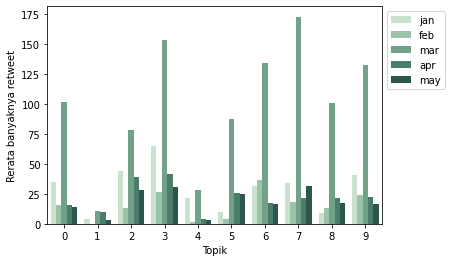

In [41]:
ret_cnt_dist = df_filtered.groupby(['month','sttm_topic']).agg({'ret_cnt': 'mean'}).reset_index()
ax = sns.barplot(x='sttm_topic', hue='month', hue_order = ['jan', 'feb', 'mar', 'apr', 'may'], y='ret_cnt', data=ret_cnt_dist, palette='ch:2.5,-.2,dark=.3');
ax.set(xlabel = 'Topik', ylabel = 'Rerata banyaknya retweet');
plt.legend(bbox_to_anchor=(1, 1));
plt.show();

Tren yang sama, di mana terdapat sangat banyak _retweet_ di bulan Maret untuk setiap topik, juga bisa diobservasi di sini. Hal lain yang bisa dilihat adalah topik 4 hanya banyak di-_retweet_ di bulan Januari dan Maret. Analisis banyaknya _like_ per topik tidak disertakan karena hasilnya hampir sama dengan analisis banyaknya _retweet_ per topik.

Hasil-hasil di atas (serta hasil-hasil penting lain) dapat dirangkum sebagai berikut:

### Kesimpulan: Pemodelan Topik

Saat melihat kata-kata representasi dari seluruh topik di kedua analisis (dengan LDA dan STTM), kami merasa topik-topik yang dihasilkan oleh STTM lebih bermakna dan menyeluruh daripada topik-topik yang dihasilkan LDA. Perbedaan terbesar dari kedua model tersebut adalah LDA berasumsi bahwa masing-masing dokumen terdiri dari campuran beberapa topik, sementara STTM berasumsi bahwa masing-masing dokumen dihasilkan oleh satu topik. Dalam kasus kami, satu dokumen merepresentasikan satu buah twit. Kami merasa bahwa sebuah twit biasanya membicarakan satu topik utama, sehingga STTM menghasilkan topik-topik yang terlihat lebih berarti dan komprehensif dalam analisis ini.

#### LDA

##### 10 topik yang dihasilkan, dari yang paling populer:
1. Topik 1: twit mengenai **_stay-at-home order_ dan _lockdown_** (35.6%)
2. Topik 2: twit mengenai **datangnya koronavirus dari Cina dan upaya negara untuk mendapatkan bantuan (alat medis) dari AS dan Cina dalam menangani koronavirus** (15.1%)
3. Topik 0: twit mengenai **harapan agar pandemi koronavirus segera berakhir** (8.5%)
4. Topik 7: twit mengenai **_lockdown_ di berbagai daerah di Indonesia dan dunia, juga rencana PSBB di Indonesia**(8.4%)
5. Topik 5: twit mengenai **kasus positif koronavirus dan pentingnya _social distancing_** (8.3%)
6. Topik 3: twit mengenai **upaya pemerintah dan POLRI dalam pencegahan penyebaran koronavirus melalui penyemprotan disinfektan** (8.2%)
7. Topik 8: twit mengenai **bantuan medis dan sosial untuk masyarakat di masa pandemi koronavirus** (6.2%)
8. Topik 9: twit mengenai **aspek medis koronavirus, termasuk berbagai informasi dan saran medis terkait koronavirus** (5.1%)
9. Topik 4: twit mengenai **mudik lebaran dan efeknya terhadap penyebaran koronavirus** (3.4%)
10. Topik 6: tidak jelas; sepertinya datang dari _spam_ (1.1%)

##### 4 topik teratas setiap bulannya:
1. Januari: topik 1 (32.7%), topik 2 (25.1%), topik 7 (17.7%)
2. Februari: topik 1 (32.8%), topik 2 (30.5%), topik 7 (8.0%)
3. Maret: topik 1 (37.2%), topik 2 (14.4%), topik 3 (10.7%)
4. April: topik 1 (32.8%), topik 2 (12.5%), topik 8 (10.2%)
5. Mei: topik 1 (37.7%), topik 0 (11.3%), topik 2 (10.0%)

##### Popularitas topik setiap bulannya:
1. Meningkat: topik 0
2. Menurun: topik 7
3. Stabil: topik 1, topik 9
4. Meningkat lalu menurun: topik 2, topik 3, topik 5, topik 8
5. Menurun lalu meningkat: topik 4, topik 6

##### Topik-topik yang paling sering di-retweet dan di-like adalah topik 2, 5 dan 9.

#### STTM

##### 10 topik yang dihasilkan, dari yang paling populer:
1. Topik 5: twit mengenai **_stay-at-home_ order dan _lockdown_, serta kegiatan-kegiatan dan keluhan selama _stay-at-home_** (21.8%)
2. Topik 3: twit mengenai **penyebaran di berbagai negara dan hubungan dengan luar negeri** (19.9%)
3. Topik 7: twit mengenai **kasus positif koronavirus, termasuk pasien yang sembuh, dan dilakukannya tes koronavirus** (11.9%)
4. Topik 2: twit mengenai **perintah _lockdown_, PSBB, dan larangan mudik di Indonesia** (11.0%)
5. Topik 8: twit mengenai **dampak pandemi koronavirus terhadap perekonomian Indonesia** (10.1%)
6. Topik 6: twit mengenai **bantuan untuk tenaga medis, dan bantuan sosial dan medis untuk masyarakat di masa pandemi koronavirus** (8.1%)
7. Topik 9: twit mengenai **upaya pencegahan penyebaran koronavirus yang bisa dilakukan masyarakat, seperti _social distancing_, menggunakan masker, dan tetap di rumah** (5.7%)
8. Topik 0: twit mengenai **koronavirus di Cina, khususnya Wuhan, dan evakuasi warga negara Indonesia** (5.2%)
9. Topik 4: twit mengenai **upaya pencegahan penyebaran koronavirus yang dilakukan pemerintah, seperti penyemprotan disinfektan oleh polisi** (5.0%)
10. Topik 1: tidak jelas; lagi-lagi ini sepertinya datang dari _spam_, dan ini konsisten dengan topik 6 dari LDA (1.3%)


##### 4 topik teratas setiap bulannya:
1. Januari: topik 3 (33.9%), topik 0 (29.7%), topik 5 (11.1%)
2. Februari: topik 3 (36.7%), topik 0 (18.2%), topik 8 (15.0%)
3. Maret: topik 5 (23.3%), topik 3 (18.2%), topik 2 (15.9%)
4. April: topik 5 (22.6%), topik 3 (15.3%), topik 7 (14.2%)
5. Mei: topik 5 (25.6%), topik 3 (15.8%), topik 2 (11.6%)

##### Popularitas topik setiap bulannya:
1. Meningkat: topik 1, topik 5
2. Menurun: topik 0
3. Stabil: topik 8
4. Meningkat lalu menurun: topik 2, topik 3, topik 4, topik 6, topik 7
5. Menurun lalu meningkat: topik 9

##### Topik-topik yang paling sering di-_retweet_ dan di-_like_ adalah topik 3 dan 7.

### Analisis _Hashtag_

Mari kita melihat 5 _hashtag_ terpopuler dari twit-twit orisinal setiap bulannya.

In [42]:
#Januari
all_hashtags = list(df_filtered[df_filtered['month'] == 'jan']['hashtags'])
all_hashtags = Counter([item for sublist in all_hashtags for item in sublist])
all_hashtags = pd.DataFrame.from_dict(all_hashtags, orient='index').reset_index()
all_hashtags.columns = ['hashtag', 'num']
all_hashtags['sum'] = np.sum(all_hashtags['num'])
all_hashtags['pct'] = 100 * all_hashtags['num']/all_hashtags['sum']
all_hashtags = all_hashtags.sort_values('pct', ascending = False).head(5)
all_hashtags

,hashtag,num,sum,pct
19,#viruscorona,372,5087,7.312758
4,#coronavirus,337,5087,6.624730
11,#waspadaviruscorona,335,5087,6.585414
39,#corona,127,5087,2.496560
1,#china,107,5087,2.103401


In [43]:
#Februari
all_hashtags = list(df_filtered[df_filtered['month'] == 'feb']['hashtags'])
all_hashtags = Counter([item for sublist in all_hashtags for item in sublist])
all_hashtags = pd.DataFrame.from_dict(all_hashtags, orient='index').reset_index()
all_hashtags.columns = ['hashtag', 'num']
all_hashtags['sum'] = np.sum(all_hashtags['num'])
all_hashtags['pct'] = 100 * all_hashtags['num']/all_hashtags['sum']
all_hashtags = all_hashtags.sort_values('pct', ascending = False).head(5)
all_hashtags

,hashtag,num,sum,pct
56,#bersamacegahcorona,573,6099,9.394983
4,#viruscorona,357,6099,5.853419
30,#coronavirus,221,6099,3.623545
1,#corona,198,6099,3.246434
2,#covid19,139,6099,2.279062


In [44]:
#Maret
all_hashtags = list(df_filtered[df_filtered['month'] == 'mar']['hashtags'])
all_hashtags = Counter([item for sublist in all_hashtags for item in sublist])
all_hashtags = pd.DataFrame.from_dict(all_hashtags, orient='index').reset_index()
all_hashtags.columns = ['hashtag', 'num']
all_hashtags['sum'] = np.sum(all_hashtags['num'])
all_hashtags['pct'] = 100 * all_hashtags['num']/all_hashtags['sum']
all_hashtags = all_hashtags.sort_values('pct', ascending = False).head(5)
all_hashtags

,hashtag,num,sum,pct
4,#covid19,1367,24649,5.545864
33,#dirumahaja,1007,24649,4.085358
43,#stayathome,596,24649,2.417948
215,#viruscorona,522,24649,2.117733
106,#31mardisinfektanmassal,440,24649,1.785062


In [45]:
#April
all_hashtags = list(df_filtered[df_filtered['month'] == 'apr']['hashtags'])
all_hashtags = Counter([item for sublist in all_hashtags for item in sublist])
all_hashtags = pd.DataFrame.from_dict(all_hashtags, orient='index').reset_index()
all_hashtags.columns = ['hashtag', 'num']
all_hashtags['sum'] = np.sum(all_hashtags['num'])
all_hashtags['pct'] = 100 * all_hashtags['num']/all_hashtags['sum']
all_hashtags = all_hashtags.sort_values('pct', ascending = False).head(5)
all_hashtags

,hashtag,num,sum,pct
2,#covid19,1133,21662,5.230357
49,#dirumahaja,672,21662,3.102207
163,#bersamapolribantuwarga,506,21662,2.335888
57,#stayathome,385,21662,1.777306
38,#viruscorona,324,21662,1.495707


In [46]:
#Mei
all_hashtags = list(df_filtered[df_filtered['month'] == 'may']['hashtags'])
all_hashtags = Counter([item for sublist in all_hashtags for item in sublist])
all_hashtags = pd.DataFrame.from_dict(all_hashtags, orient='index').reset_index()
all_hashtags.columns = ['hashtag', 'num']
all_hashtags['sum'] = np.sum(all_hashtags['num'])
all_hashtags['pct'] = 100 * all_hashtags['num']/all_hashtags['sum']
all_hashtags = all_hashtags.sort_values('pct', ascending = False).head(5)
all_hashtags

,hashtag,num,sum,pct
11,#covid19,1060,25309,4.188233
51,#dirumahajalebihbaik,868,25309,3.429610
49,#patuhiprotokolcovid19,678,25309,2.678889
23,#dirumahaja,603,25309,2.382552
190,#polriberbagikasih,487,25309,1.924217


Di bawah ini disajikan visualisasi frekuensi kemunculan _hashtag-hashtag_ secara keseluruhan (dari bulan Januari sampai Mei).

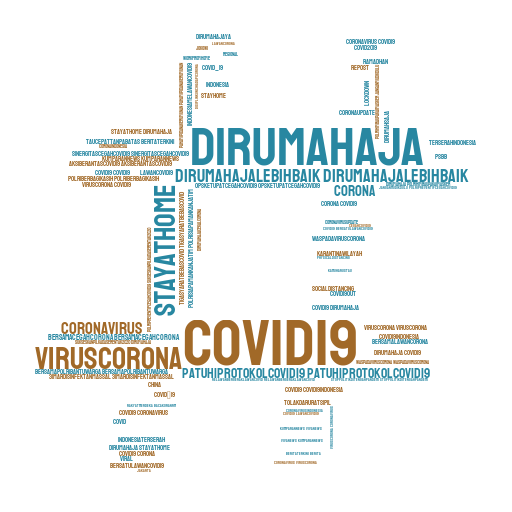

In [85]:
df_filtered['hashtags_texts'] = df_filtered['hashtags'].apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_filtered['hashtags_texts'].values))
stylecloud.gen_stylecloud(text=long_string, icon_name='fas fa-hashtag', max_words=100, palette='cartocolors.diverging.Earth_2', output_name='hashtags.png')
Image.open('hashtags.png')

Dari analisis ini, kita bisa melihat bahwa _hashtag-hashtag_ terpopuler berubah setiap bulannya. Pada bulan Januari dan Februari, _hashtag-hashtag_ populer cenderung bersifat umum. Pada bulan Maret, _hashtag_ yang berhubungan dengan _stay-at-home_ mulai bermunculan setelah meningkatnya kasus koronavirus di Indonesia. _Hashtag_ yang berhubungan dengan POLRI pun mulai banyak digunakan semenjak Maret, seperti $\texttt{#31mardisinfektanmassal}$, $\texttt{#bersamapolribantuwarga}$, $\texttt{	#patuhiprotokolcovid19}$ dan $\texttt{#polriberbagikasih}$.

### Keterbatasan

Studi ini memiliki berbagai keterbatasan, di antaranya:
1. Twit-twit untuk analisis ini didapatkan dari _tweet ID_ yang disaring oleh Chen et al. (2020). Dalam makalah penelitiannya, dijelaskan bahwa _tweet ID_ tersebut diperoleh menggunakan API _streaming_ gratis dari Twitter, yang hanya menghasilkan 1% dari keseluruhan twit
2. Hanya twit-twit berbahasa Indonesia yang dianalisis. Selain itu, penyaringan lokasi yang kami lakukan membuang sejumlah twit berbahasa Indonesia yang ditulis oleh pengguna yang tidak mencamtukan lokasi (atau pengguna dengan lokasi yang tidak umum)
3. Kami hanya mengambil sampel 7 hari terakhir pada tiap bulan (kecuali Mei, di mana sampel kami adalah twit-twit yang ditulis pada pertengahan Mei) untuk merepresentasikan bulan-bulan tersebut. Hal ini dikarenakan lamanya pengambilan twit-twit dan atributnya akibat pembatasan yang diberlakukan Twitter.
4. Kami tidak melakukan _hyperparameter tuning_ secara komprehensif untuk model LDA dan STTM yang digunakan.